# 분류모델 평가 방법

## 정확도

### MNIST 손글씨 데이터 활용

In [7]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

In [6]:
# 숫자 손글씨 데이터 로드

digits = load_digits()

# x y 데이터 객체화
x_datas = digits.data
y_datas = digits.target

x_datas.shape, y_datas.shape

((1797, 64), (1797,))

In [27]:
# y_data의 숫자 개수 확인
pd.Series(y_datas).value_counts()

3    183
1    182
5    182
4    181
6    181
9    180
7    179
0    178
2    177
8    174
dtype: int64

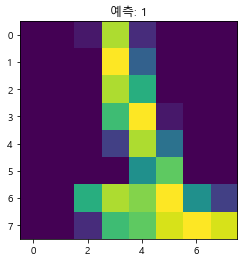

In [25]:
# 시각화
# 한글 쓸 때 활용
mpl.rc('font', family = 'Malgun Gothic')

plt.imshow(x_datas[1000].reshape(8,8))
plt.title(f'예측: {y_datas[1000]}')
plt.show()

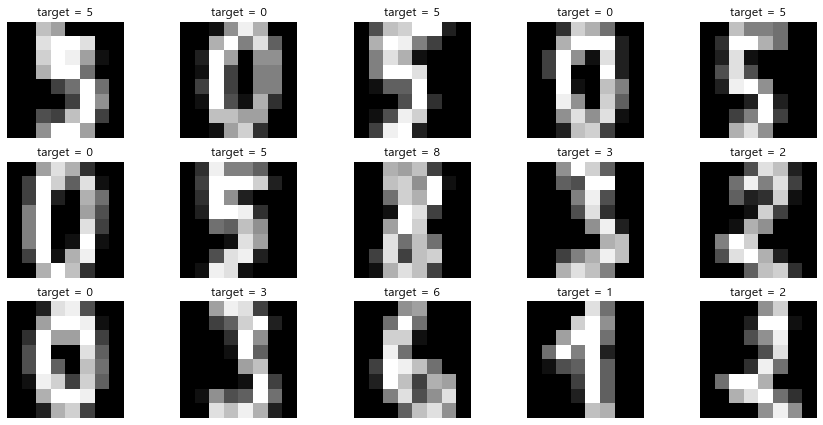

In [24]:
# 여러개 시각화

plt.figure(figsize = (15, 15))

# 여러개 서브플랏 만들 때 활용
for i in range(15):
    plt.subplot(6, 5, i + 1)
    plt.imshow(x_datas[(i+1) * 5].reshape(8,8), cmap = 'gray')
    plt.title(f'target = {y_datas[(i+1) * 5]}')
    # x축 y축 표시 안함
    plt.axis('off')
    
# 마지막에 써야함
plt.show()

In [33]:
class MyFakeClassifier(BaseEstimator):
    def fit(sef, X, y):
        pass
    
    # 입력값으로 들어오는 x데이터 세트의 크기만큼 모두 0으로 만들어서 반환
    def predict(self, X):
        return np.zeros((len(X), 1), dtype = bool)

In [36]:
# 7 여부를 배열로 반환해서 불균형한 데이터로 변환
y = (y_datas == 7).astype(int)

print(pd.Series(y).value_counts())

# 학습/테스트용 데이터 나누기
X_train, X_test, y_train, y_test = train_test_split(x_datas, y, 
                                                    random_state = 11)

# dummy classifier로 학습/예측/정확도 평가
fakeclf = MyFakeClassifier()
fakeclf.fit(X_train, y_train)

fakepred = fakeclf.predict(X_test)

print(pd.Series(y_test).value_counts())
# 모든 예측을 0으로 해도 예측 정확도는 90프로가 나옴-> 불균형 데이터셋에 대한 분류 평가기준은 정확도로만은 안됨!
accuracy_score(y_test, fakepred)

0    1618
1     179
dtype: int64
0    405
1     45
dtype: int64


0.9

## 오차 행렬

In [37]:
from sklearn.metrics import confusion_matrix

In [38]:
# [[TN, FP], [FN, TP]]
# [[실제 N/예측 N, 실제 N/예측 P], [실제 P/예측 N, 실제 P/예측 P]]

confusion_matrix(y_test, fakepred)

array([[405,   0],
       [ 45,   0]], dtype=int64)

## 정밀도와 재현율

### 타이타닉 활용

In [42]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import pandas as pd

In [78]:
# 평가 결과 반환하는 사용자함수 생성

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    
    print(f'오차 행렬: \n{confusion}')
    print(f'정확도: {accuracy}')
    print(f'정밀도: {precision}')
    print(f'재현율: {recall}')

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression

In [50]:
## Null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace=True)
    df['Embarked'].fillna('N', inplace=True)
    df['Fare'].fillna(0, inplace=True)
    return df

## 머신러닝에 불필요한 피처 제거
def drop_features(df):
    df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
    return df

## Label Encoding 수행
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = LabelEncoder()
        le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [57]:
# 로지스틱 회귀를 기반으로 타이타닉 생존자 예측
tit_df = pd.read_csv('./필요데이터/titanic_train.csv')
display(tit_df.head())

y = tit_df['Survived']
x = tit_df.drop(['Survived'], axis = 1)
x = transform_features(x)
display(x)
print(x.shape)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,1,22.000000,1,0,7.2500,7,3
1,1,0,38.000000,1,0,71.2833,2,0
2,3,0,26.000000,0,0,7.9250,7,3
3,1,0,35.000000,1,0,53.1000,2,3
4,3,1,35.000000,0,0,8.0500,7,3
...,...,...,...,...,...,...,...,...
886,2,1,27.000000,0,0,13.0000,7,3
887,1,0,19.000000,0,0,30.0000,1,3
888,3,0,29.699118,1,2,23.4500,7,3
889,1,1,26.000000,0,0,30.0000,2,0


(891, 8)


In [70]:
# 학습용/테스트용 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(x, y)


# 학습
lr_clf = LogisticRegression(solver = 'liblinear')  
        ## solver: 로지스틱 회귀의 최적화 알고리즘 유형 지정
        ## solver = 'liblinear': 작은 데이터 셋 & 이진 분류의 경우 성능이 좋아지는 경향 있음
        ## solver = 'lbfgs': 큰 데이터 셋 & 다중 분류의 경우 적합, default 값
lr_clf.fit(X_train, y_train)

# 예측
pred_proba = lr_clf.predict_proba(X_test) # 0,1에 대한 예측 확률
pred = lr_clf.predict(X_test) # 예측 확률이 높은 이진값을 반환

print(np.concatenate([pred_proba, pred.reshape(-1,1)], axis = 1)[:10])


# 평가
get_clf_eval(y_test, pred)

[[0.8974367  0.1025633  0.        ]
 [0.50243031 0.49756969 0.        ]
 [0.87519803 0.12480197 0.        ]
 [0.96705431 0.03294569 0.        ]
 [0.91202844 0.08797156 0.        ]
 [0.6747154  0.3252846  0.        ]
 [0.48146714 0.51853286 1.        ]
 [0.40928427 0.59071573 1.        ]
 [0.86921299 0.13078701 0.        ]
 [0.19926685 0.80073315 1.        ]]
오차 행렬: 
[[122  14]
 [ 29  58]]
정확도: 0.8071748878923767
정밀도: 0.8055555555555556
재현율: 0.6666666666666666


In [76]:
# 예측2
## 임곗값을 다르게 설정해보기

from sklearn.preprocessing import Binarizer

## 임곗값을 0.5로 설정

x_example = pred_proba[:10]

binarizer = Binarizer(threshold = 0.5)
print(binarizer.fit_transform(x_example))

## 임곗값을 0.3으로 설정
x_example2 = pred_proba[:,1].reshape(-1, 1)
c
binarizer = Binarizer(threshold = 0.3)
y_pred2 = binarizer.fit_transform(x_example2)
print(y_pred2[:10])

## 평가
get_clf_eval(y_pred2, y_test)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]
[[0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]]
오차 행렬: 
[[108  22]
 [ 28  65]]
정확도: 0.7757847533632287
정밀도: 0.7471264367816092
재현율: 0.6989247311827957


In [85]:
# threshold에 따라 평가해주는 사용자 함수 생성

threshold = [0.4, 0.45, 0.5, 0.55, 0.6]
def get_clf_eval_by_threshold(y_test, pred_proba_c1, threshold):
    for custom_threshold in threshold:
        binarizer = Binarizer(threshold = custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.fit_transform(pred_proba_c1)
        
        print(f'임곗값: {custom_threshold}')
        get_clf_eval(y_test, custom_predict)
        print('\n')

get_clf_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1,1), threshold)    

임곗값: 0.4
오차 행렬: 
[[116  20]
 [ 29  58]]
정확도: 0.7802690582959642
정밀도: 0.7435897435897436
재현율: 0.6666666666666666


임곗값: 0.45
오차 행렬: 
[[118  18]
 [ 29  58]]
정확도: 0.7892376681614349
정밀도: 0.7631578947368421
재현율: 0.6666666666666666


임곗값: 0.5
오차 행렬: 
[[122  14]
 [ 29  58]]
정확도: 0.8071748878923767
정밀도: 0.8055555555555556
재현율: 0.6666666666666666


임곗값: 0.55
오차 행렬: 
[[125  11]
 [ 30  57]]
정확도: 0.8161434977578476
정밀도: 0.8382352941176471
재현율: 0.6551724137931034


임곗값: 0.6
오차 행렬: 
[[125  11]
 [ 33  54]]
정확도: 0.8026905829596412
정밀도: 0.8307692307692308
재현율: 0.6206896551724138




In [86]:
from sklearn.metrics import precision_recall_curve

In [94]:
# precision_recall_curve 인자는 (실제값, 클래스가 1인 예측값)이 들어감
pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]


# 정밀도, 재현율, 임곗값 반환(임곗값이 한개 더 많음)
precision, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
print(f'반환된 임곗값 배열 shape: {thresholds.shape}')


반환된 임곗값 배열 shape: (203,)


In [106]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline

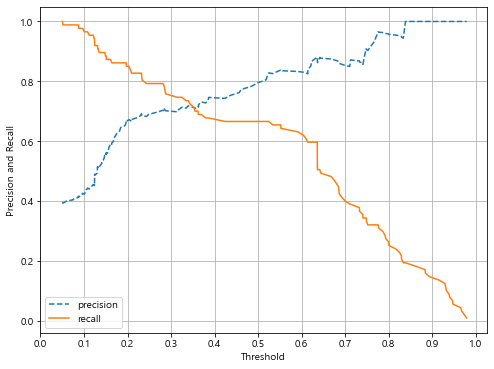

In [114]:
# 시각화

def precision_reall_curve_plot(y_test, pred_proba_class1):
    precision, recall, threshold = precision_recall_curve(y_test, pred_proba_class1)
    
    plt.figure(figsize = (8,6))
    plt.plot(threshold, precision[:-1], linestyle = '--', label = 'precision')
    plt.plot(threshold, recall[:-1], label = 'recall')
    plt.xticks(np.arange(0, 1.1, 0.1) )
    plt.xlabel('Threshold')
    plt.ylabel('Precision and Recall')
    plt.legend()
    plt.grid()
    plt.show()
    
precision_reall_curve_plot(y_test, pred_proba_class1)

## f1 score

In [115]:
from sklearn.metrics import f1_score

In [116]:
f1 = f1_score(y_test, pred)
f1

0.7295597484276728

In [120]:
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    
    print(f'오차행렬:\n{confusion}')
    print(f'정확도: {accuracy}')
    print(f'정밀도: {precision}')
    print(f'재현율: {recall}')
    print(f'f1스코어: {f1}')
    
threshold = [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6]
def get_clf_eval_by_threshold(y_test, pred_proba_c1, threshold):
    for custom_threshold in threshold:
        binarizer = Binarizer(threshold = custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.fit_transform(pred_proba_c1)
        
        print(f'임곗값: {custom_threshold}')
        get_clf_eval(y_test, custom_predict)
        print('\n')

get_clf_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1,1), threshold)  

임곗값: 0.3
오차행렬:
[[108  28]
 [ 22  65]]
정확도: 0.7757847533632287
정밀도: 0.6989247311827957
재현율: 0.7471264367816092
f1스코어: 0.7222222222222223


임곗값: 0.35
오차행렬:
[[111  25]
 [ 25  62]]
정확도: 0.7757847533632287
정밀도: 0.7126436781609196
재현율: 0.7126436781609196
f1스코어: 0.7126436781609196


임곗값: 0.4
오차행렬:
[[116  20]
 [ 29  58]]
정확도: 0.7802690582959642
정밀도: 0.7435897435897436
재현율: 0.6666666666666666
f1스코어: 0.7030303030303031


임곗값: 0.45
오차행렬:
[[118  18]
 [ 29  58]]
정확도: 0.7892376681614349
정밀도: 0.7631578947368421
재현율: 0.6666666666666666
f1스코어: 0.7116564417177914


임곗값: 0.5
오차행렬:
[[122  14]
 [ 29  58]]
정확도: 0.8071748878923767
정밀도: 0.8055555555555556
재현율: 0.6666666666666666
f1스코어: 0.7295597484276728


임곗값: 0.55
오차행렬:
[[125  11]
 [ 30  57]]
정확도: 0.8161434977578476
정밀도: 0.8382352941176471
재현율: 0.6551724137931034
f1스코어: 0.735483870967742


임곗값: 0.6
오차행렬:
[[125  11]
 [ 33  54]]
정확도: 0.8026905829596412
정밀도: 0.8307692307692308
재현율: 0.6206896551724138
f1스코어: 0.7105263157894737




## ROC 곡선

In [131]:
from sklearn.metrics import roc_curve

In [132]:
pred_proba_Class1 = lr_clf.predict_proba(X_test)[:, 1]

# roc_curve의 인자는 (실제값, 긍정 예측값), 반환값은 fpr(1-특이도), tpr(민감도), 임곗값
fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)
fprs.shape, tprs.shape, thresholds.shape

((70,), (70,), (70,))

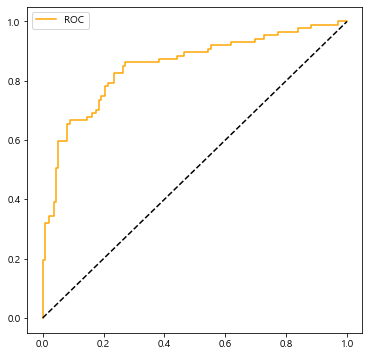

In [138]:
# 시각화

def roc_curve_plot(y_test, pred_proba_class1):
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)
    
    mpl.rc('font', family = 'Malgun Gothic')
    plt.figure(figsize = (6,6))
    plt.plot(fprs, tprs, label = 'ROC', color = 'orange')
    plt.plot([0,1], [0, 1], 'k--')
    plt.legend()
    plt.show()

roc_curve_plot(y_test, pred_proba_class1)

## AUC SCORE

In [140]:
from sklearn.metrics import roc_auc_score

In [141]:
roc_auc_score(y_test, pred_proba_class1)

0.8497295469912103

In [142]:
# 최종 get_clf_eval 사용자 함수

def get_clf_eval(y_test, pred = None, pred_proba_class1 = None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    recall = recall_score(y_test, pred)
    precision = precision_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    auc = roc_auc_score(y_test, pred_proba_class1)
    
    print(f'오차행렬:\n{confusion}')
    print(f'정확도: {accuracy}')
    print(f'정밀도: {precision}')
    print(f'재현율: {recall}')
    print(f'f1스코어: {f1}')
    print(f'auc 스코어: {auc}')

# 실습: 피마 인디언 당뇨병 예측

In [182]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve

In [149]:
# 데이터 불러오기
diabetes_data = pd.read_csv('./필요데이터/diabetes.csv')
diabetes_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [150]:
# EDA
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [151]:
diabetes_data['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In [161]:
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


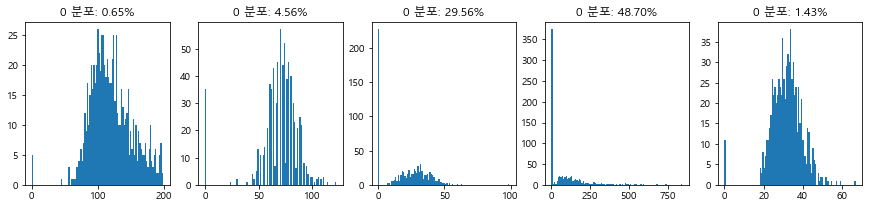

In [174]:
# 0 값을 많이 가지는 피처만 시각화 
features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

plt.figure(figsize = (15, 3))
for i in range(len(features)):
    plt.subplot(1,5, i + 1)
    plt.hist(diabetes_data[features[i]], bins = 100)
    pct = len(diabetes_data[diabetes_data[features[i]] == 0])/len(diabetes_data[features[i]])
    plt.title(f'0 분포: {pct * 100:.2f}%')
plt.show()


In [157]:
# 모델링

## 데이터 분할
X = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 156, stratify = y)
     ## stratify = y : 원래 데이터분포에 맞게 계층적 추출하는 방법

y.value_counts(), y_train.value_counts(), y_test.value_counts()

(0    500
 1    268
 Name: Outcome, dtype: int64,
 0    400
 1    214
 Name: Outcome, dtype: int64,
 0    100
 1     54
 Name: Outcome, dtype: int64)

In [159]:
# 학습
lr_clf = LogisticRegression(solver = 'liblinear')

lr_clf.fit(X_train, y_train)

# 예측
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, pred, pred_proba)

오차행렬:
[[87 13]
 [22 32]]
정확도: 0.7727272727272727
정밀도: 0.7111111111111111
재현율: 0.5925925925925926
f1스코어: 0.6464646464646464
auc 스코어: 0.8083333333333333


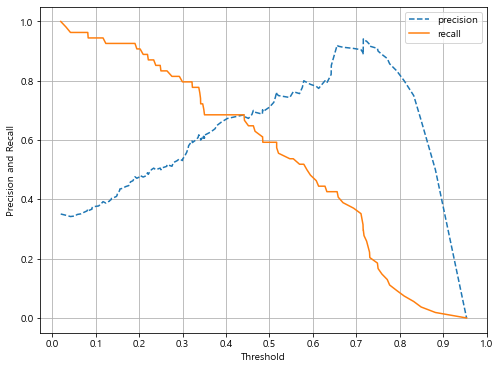

In [160]:
# 임곗값에 따른 정밀도-재현율 곡선 시각화

precision_reall_curve_plot(y_test, pred_proba)
      ## 임곗값이 0.45가 적절해보임

In [179]:
# 0값을 각 피처에서 0을 제외한 평균값으로 대체
for feature in features:
    mean_feature = diabetes_data[diabetes_data[feature] != 0][feature].mean()
    print(f'feature: {feature}\n평균값:{mean_feature}\n')
    
    diabetes_data[feature] = diabetes_data[feature].replace(0, mean_feature)    
    
diabetes_data.describe()

feature: Glucose
평균값:121.6867627785059

feature: BloodPressure
평균값:72.40518417462484

feature: SkinThickness
평균값:29.153419593345657

feature: Insulin
평균값:155.5482233502538

feature: BMI
평균값:32.45746367239099



,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.153420,155.548223,32.457464,0.471876,33.240885,0.348958
std,3.369578,30.435949,12.096346,8.790942,85.021108,6.875151,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,25.000000,121.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.202592,29.153420,155.548223,32.400000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,155.548223,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


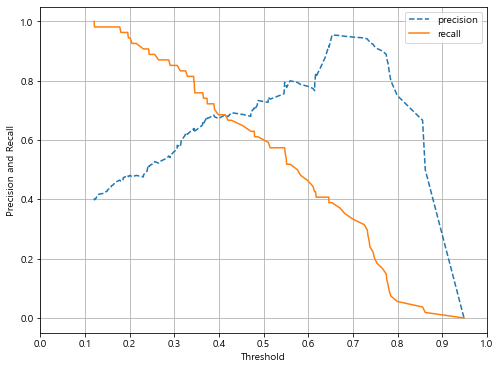

In [201]:
X = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:, -1]

# minmax 정규화
scaler = MinMaxScaler()

x_scaled = scaler.fit_transform(X)


# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 156, stratify = y)

# 학습
lr_clf = LogisticRegression(solver = 'liblinear')
lr_clf.fit(X_train, y_train)

# 예측
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:, 1]

# 정밀도 재현율 곡선 
precision_reall_curve_plot(y_test, pred_proba)


In [216]:
# 평가
def get_clf_eval(y_test, pred, pred_proba):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    
    print(f'오차행렬:\n{confusion}')
    print(f'정확도: {accuracy: .2f}')
    print(f'정밀도: {precision: .2f}')
    print(f'재현율: {recall: .2f}')
    print(f'f1스코어: {f1: .2f}')
    print(f'roc_auc스코어: {roc_auc: .2f}')
    
def get_clf_eval_by_threshold(y_test, pred_proba_c1, threshold):
    for custom_threshold in threshold:
        binarizer = Binarizer(threshold = custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.fit_transform(pred_proba_c1)
        
        print(f'임곗값: {custom_threshold}')
        get_clf_eval(y_test, custom_predict, pred_proba_c1)
        print('\n')


threshold = [0.3, 0.33, 0.36, 0.4, 0.43, 0.46, 0.49]
get_clf_eval_by_threshold(y_test, pred_proba.reshape(-1,1), threshold)

임곗값: 0.3
오차행렬:
[[65 35]
 [ 8 46]]
정확도:  0.72
정밀도:  0.57
재현율:  0.85
f1스코어:  0.68
roc_auc스코어:  0.85


임곗값: 0.33
오차행렬:
[[74 26]
 [10 44]]
정확도:  0.77
정밀도:  0.63
재현율:  0.81
f1스코어:  0.71
roc_auc스코어:  0.85


임곗값: 0.36
오차행렬:
[[78 22]
 [13 41]]
정확도:  0.77
정밀도:  0.65
재현율:  0.76
f1스코어:  0.70
roc_auc스코어:  0.85


임곗값: 0.4
오차행렬:
[[83 17]
 [17 37]]
정확도:  0.78
정밀도:  0.69
재현율:  0.69
f1스코어:  0.69
roc_auc스코어:  0.85


임곗값: 0.43
오차행렬:
[[84 16]
 [19 35]]
정확도:  0.77
정밀도:  0.69
재현율:  0.65
f1스코어:  0.67
roc_auc스코어:  0.85


임곗값: 0.46
오차행렬:
[[84 16]
 [20 34]]
정확도:  0.77
정밀도:  0.68
재현율:  0.63
f1스코어:  0.65
roc_auc스코어:  0.85


임곗값: 0.49
오차행렬:
[[88 12]
 [22 32]]
정확도:  0.78
정밀도:  0.73
재현율:  0.59
f1스코어:  0.65
roc_auc스코어:  0.85




- 책과 다르게 0값을 채울 때, 0을 포함하지 않은 평균값으로 대체해주었는데, 이게 결론적으로 좋은 임곗값을 고르는 부분에서 책과 차이가 나는 부분인 것 같다.
- 정밀도가 좀 낮게 나온편이긴 하지만, 재현율이 높고, f1스코어 역시 높기 때문에 제일 좋은 임곗값은 0.33인 것으로!